In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
from pylab import *
from sklearn.feature_selection import f_regression, mutual_info_regression
from scipy import stats
import seaborn as sns
import xarray as xr
import pdb
import os

In [2]:
def cons_count_rever(df,var,count):
    df_copy = pd.concat([df,(df[var].notnull().astype(int)
            .groupby(df[var].isnull().astype(int).cumsum())
            .cumsum().to_frame(count))], axis=1)
    
    df_m24 = df_copy[df_copy['consec_count']>=24] 
    index_24 = df_copy[df_copy['consec_count']==24].index
    
    df_p24 = pd.DataFrame()
    for i in range(len(index_24)):
        z = df.loc[(index_24 - pd.Timedelta(23,unit='h')).strftime('%Y-%m-%d %X')[i] : 
                    index_24.strftime('%Y-%m-%d %X')[i]]
        df_p24 = df_p24.append(z, ignore_index=False)
    dates = pd.concat([df_m24, df_p24], axis=1).index
    
    df_fin = df[df.index.isin(dates)]

    return(df_fin)

def var_data(filename,path,var,varname):
    ds = xr.open_dataset(path+filename)
    if var == 'tpwGrid':
        value = np.array(ds[var]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-10-01','2020-01-01', freq='1D')]
    elif var == 'tope':
        value = np.array(ds[var]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-01-01','2019-12-31 23:00:00', 
                                                                        freq='1H')]
    else:
        value = np.array(ds[var][0:1461]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-01-01','2019-12-31', freq='1D')]
    temp = pd.DataFrame(np.column_stack((fecha,value)),columns = ['Dates',varname])
    temp.to_csv(path+var+'_data.csv', index = False)
    del(temp)
    varia = pd.read_csv(path+var+'_data.csv', index_col=0, parse_dates = True)
    return(varia)

def vert_means(data, spe):
    lista = np.array([])
    for i,var in enumerate(spe):
        lista = np.append(lista, data[var].mean())
    return(lista)

In [3]:
def daily_states(latitud,longitud,fac,daily):
    ### This is used to input the lat, lon and factor, to calculate the reversals and organised days!
    ### This also select the days in the meteorological variables! and calculate the daymean!
    ### C fraction is in other file, as would probably happen also for the cloud properties!
    ### This means that those variables are not in the same DataFrame, not in the met one!
    ### The True statement is to select if we want the daily values, or hourly, but careful with other variables
    ### Such as CTOP or cloud properties!, since they are daily!
    path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/Area_'+latitud+'_'+longitud+'_ERA5/'
    #### Read Data
    slopes = pd.read_csv(path+'Slopes_data_ERA5.csv', parse_dates = True, index_col = 0)
    met_data= pd.read_csv(path+'Complete_met_data.csv', parse_dates = True, index_col = 0)
    met_data['CIN'] = met_data['CIN'].fillna(value=met_data['CIN'].mean())
    utc = 0
    slopes.index = slopes.index - pd.Timedelta(utc,unit='h')
    met_data.index = met_data.index - pd.Timedelta(utc,unit='h')
    ## Extra vars, they have to be added at the end also
    ctop = var_data('cloud_area.nc', path, 'tope', 'CTop') 
    ctop['CTop'] = ctop['CTop'].fillna(value=ctop['CTop'].mean())
    ### Select the reversals and organize states
    slopes_crit_lo=-fac*slopes.std()[0] # slopes_sd # critical threshold for an event
    slopes_crit_hi=fac*slopes.std()[0] # slopes_sd # critical threshold for an event
    slopes_mask_lo=slopes[slopes<slopes_crit_lo]
    slopes_mask_hi=slopes[slopes>slopes_crit_hi]
    ### Here we produce the counts and select the days with reversals and with organized states!!!
    # First the states in the slopes
    df_slop_lo = cons_count_rever(slopes_mask_lo, 'Slope', 'consec_count')
    df_slop_hi = cons_count_rever(slopes_mask_hi, 'Slope', 'consec_count')
    df_slop_ne = pd.concat([slopes, df_slop_lo]).drop_duplicates(keep=False)
    df_slop_ne = pd.concat([df_slop_ne, df_slop_hi]).drop_duplicates(keep=False)
    #Second select those days in the meteorological data!
    met_lo_data = met_data[met_data.index.isin(df_slop_lo.index)]
    met_hi_data = met_data[met_data.index.isin(df_slop_hi.index)]
    met_ne_data = pd.concat([met_data, met_lo_data]).drop_duplicates(keep=False)
    met_ne_data = pd.concat([met_ne_data, met_hi_data]).drop_duplicates(keep=False)
    if daily == True:
        ### Daymean and selection of variables that are not on the met_data variable
        ### If some variable is missing, it is better to put it here, at the end!
        ### If a variable is added here, it need to be also added to the return! 
        ### CTOP is only daily resolution! so it can not be included in the total met data as hourly!
        daymean_t = met_data.resample('D').mean().dropna()
        daymean_lo = met_lo_data.resample('D').mean().dropna()
        daymean_hi = met_hi_data.resample('D').mean().dropna()
        daymean_ne = met_ne_data.resample('D').mean().dropna()

        daymean_st = slopes.resample('D').mean().dropna()
        daymean_slo = df_slop_lo.resample('D').mean().dropna()
        daymean_shi = df_slop_hi.resample('D').mean().dropna()
        daymean_sne = df_slop_ne.resample('D').mean().dropna()

        #Clod TOP
        daymean_ctt = ctop.resample('D').mean().dropna()
        daymean_ctlo = daymean_ctt[daymean_ctt.index.isin(daymean_lo.index)]
        daymean_cthi = daymean_ctt[daymean_ctt.index.isin(daymean_hi.index)]
        daymean_ctne = daymean_ctt[daymean_ctt.index.isin(daymean_ne.index)]
        return(daymean_t,daymean_lo,daymean_hi,daymean_ne,
               daymean_st,daymean_slo,daymean_shi,daymean_sne,
               daymean_ctt,daymean_ctlo,daymean_cthi,daymean_ctne)
    else: 
        return(slopes, df_slop_lo, df_slop_hi, df_slop_ne,
               met_data, met_lo_data, met_hi_data, met_ne_data)

In [133]:
def RRTMG_nat(sst,moist,ctop,air_T,r_ice,ciwp,r_liq,clwp,press,himawari):
    import climlab
    alb = 0.25
    state = climlab.column_state(lev=np.array(press))
    state.Ts[0] = sst.mean()
    state.Tatm[:] = air_T
    lev = state.Tatm.domain.axes['lev'].points
    if himawari == True:
        cldfrac = ctop.mean()
    else:
        cldfrac = ctop
    
    #CRE_LW = {}
    #CRE_SW = {}
    for thickness in ciwp:
        for i in range(lev.size):
            # Whole-column cloud characteristics
            #  The cloud fraction is a Gaussian bump centered at the current level, when a exp is in there! 
            if himawari == False:
                mycloud = {'cldfrac': cldfrac,
                           'ciwp': np.zeros_like(state.Tatm) + ciwp[thickness],
                           'r_ice': np.zeros_like(state.Tatm) + r_ice,
                           'clwp': np.zeros_like(state.Tatm) + clwp[thickness],
                           'r_liq': np.zeros_like(state.Tatm) + r_liq,}
            else:
                mycloud = {'cldfrac': cldfrac*np.exp(-(lev-lev[i])**2/(2*25.)**2),
                           'ciwp': np.zeros_like(state.Tatm) + ciwp[thickness],
                           'r_ice': np.zeros_like(state.Tatm) + r_ice,
                           'clwp': np.zeros_like(state.Tatm) + clwp[thickness],
                           'r_liq': np.zeros_like(state.Tatm) + r_liq,}
            
            #pdb.set_trace()
            rad_diag = climlab.radiation.RRTMG(state=state, 
                        albedo=alb,
                        specific_humidity=moist,
                        verbose=False,
                        **mycloud)
            rad_diag.compute_diagnostics()
        #CRE_LW[thickness] = (rad_diag.TdotLW - rad_diag.TdotLW_clr)
        #CRE_SW[thickness] = (rad_diag.TdotSW - rad_diag.TdotSW_clr)    
    return(rad_diag)

def cambio_list(data,days):
    chan = []
    for day in days:
        day = int(day)
        chan.append(data[day])
    return(chan)

In [155]:
def exp_rrtmg(sst,hum,tem,cfr,ciwp,clwp,pres_long):
    r_ice = 25.
    r_liq = 14.
    rad = RRTMG_nat(sst,hum,cfr,tem,
                    r_ice,{'med': ciwp*1000,},
                    r_liq,{'med': clwp*1000,},
                    np.array(pres_long), False)
    return(rad.LW_flux_up[0]*-1,rad.LW_flux_up[-1]*-1,rad.LW_flux_up_clr[0]*-1,rad.LW_flux_up_clr[-1]*-1)

In [367]:
def battery_exp(varis,rads,days,exp_inp,area,tipo,pres_long):
    ### To save the output
    exps_bat = {'SST_OLR':[],'SST_OLRclr':[], 'SST_SFC':[],'SST_SFCclr':[], 
                'Hum_OLR':[],'Hum_OLRclr':[], 'Hum_SFC':[],'Hum_SFCclr':[],
                'Temp_OLR':[],'Temp_OLRclr':[], 'Temp_SFC':[],'Temp_SFCclr':[],
                'Clouds_OLR':[],'Clouds_OLRclr':[], 'Clouds_SFC':[],'Clouds_SFCclr':[]}
    for i,var in enumerate(varis):
        if var == 'Clouds':
            chci = cambio_list(exp_inp[var][4],days)
            chcl = cambio_list(exp_inp[var][5],days)
        change = cambio_list(exp_inp[var][i],days)
        for day in days:
            day = int(day)
            print(var+' day: '+str(day)+' of '+str(int(days[-1])))
            for j,chan in enumerate(change):
                if var == 'SST':
                    olr,sfc,olrclr,sfcclr = exp_rrtmg(chan,
                                                      exp_inp[var][1][day],
                                                      exp_inp[var][2][day],
                                                      exp_inp[var][3][day],
                                                      exp_inp[var][4][day]*1000,
                                                      exp_inp[var][5][day]*1000,
                                                      pres_long)
                elif var == 'Hum':
                    olr,sfc,olrclr,sfcclr = exp_rrtmg(exp_inp[var][0][day],
                                                      chan,
                                                      exp_inp[var][2][day],
                                                      exp_inp[var][3][day],
                                                      exp_inp[var][4][day]*1000,
                                                      exp_inp[var][5][day]*1000,
                                                      pres_long)
                elif var == 'Temp':
                    olr,sfc,olrclr,sfcclr = exp_rrtmg(exp_inp[var][0][day],
                                                      exp_inp[var][1][day],
                                                      chan,
                                                      exp_inp[var][3][day],
                                                      exp_inp[var][4][day]*1000,
                                                      exp_inp[var][5][day]*1000,
                                                      pres_long)
                elif var == 'Clouds':
                    olr,sfc,olrclr,sfcclr = exp_rrtmg(exp_inp[var][0][day],
                                                      exp_inp[var][1][day],
                                                      exp_inp[var][2][day],
                                                      chan,chci[j]*1000,
                                                      chcl[j]*1000,pres_long)
                ### Adding results to a dictionary
                exps_bat[var+'_OLR'].append(olr)
                exps_bat[var+'_SFC'].append(sfc)
                exps_bat[var+'_OLRclr'].append(olrclr)
                exps_bat[var+'_SFCclr'].append(sfcclr)
                
    path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/'
    df_exp = pd.DataFrame.from_dict(exps_bat)
    df_exp.to_csv(path+'RRTMG_exp_'+tipo+'_'+area+'.csv')
    return(df_exp)

In [371]:
def real_rrtmg(days,exp_inp,area,name,pres_long):
    exps_bat = {'OLR':[],'OLRclr':[], 'SFC':[],'SFCclr':[]}
    for day in days:
        day = int(day)
        print(name+' day: '+str(day)+' of '+str(int(days[-1])))
        olr,sfc,olrclr,sfcclr = exp_rrtmg(exp_inp['Real'][0][day],
                                          exp_inp['Real'][1][day],
                                          exp_inp['Real'][2][day],
                                          exp_inp['Real'][3][day],
                                          exp_inp['Real'][4][day]*1000,
                                          exp_inp['Real'][5][day]*1000,
                                          pres_long)
        exps_bat['OLR'].append(olr)
        exps_bat['SFC'].append(sfc)
        exps_bat['OLRclr'].append(olrclr)
        exps_bat['SFCclr'].append(sfcclr)
    
    path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/'
    df_exp = pd.DataFrame.from_dict(exps_bat)
    df_exp.to_csv(path+'RRTMG_'+name+'_'+area+'.csv')
    return(df_exp)

In [5]:
def plot_vert_rrtmg(revs,orgis,xlabel):
    linestyle = ['--','-','-.']
    titles = ['(a)','(b)','(c)']
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1,3, left=0.05, right=0.975, hspace=0.25, wspace=0.1, top=0.9, bottom=0.1)
    for i,rev in enumerate(revs):
        ax=subplot(gs[i])
        plt.plot(rev, pres_long, color = 'darkorchid', linestyle = linestyle[i], label = 'Reversals')
        plt.plot(orgis[i], pres_long, color = 'blue', linestyle = linestyle[i], label = 'Reversals')
        plt.ylim(1000,100)
        plt.xlabel(xlabel)
        plt.grid(linestyle=':')
        plt.title(titles[i], fontweight='bold', loc = 'left')
        plt.axvline(0,linestyle = '--', color = 'k', linewidth=0.75)
        if i == 0:
            plt.ylabel('Pressure')
        else:
            ax.yaxis.set_major_formatter(NullFormatter())
        if i == 1:
            plt.legend(frameon=False, ncol = 2, loc = 'upper center', bbox_to_anchor=(0.5,1.075))
            
def plot_sct_RRTMG(revs,orgs):
    xaxis = np.arange(0,3)
    titles = ['(a)','(b)','(c)','(d)']
    ylabel = ['LW Top Net Total (W m$^{-2}$)', 'LW Sfc Upw Total (W m$^{-2}$)', 
              'LWclr Top Net Total (W m$^{-2}$)', 'LWclr Sfc Upw Total (W m$^{-2}$)']

    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.25, wspace=0.4, top=0.9, bottom=0.1)

    for i,rev in enumerate(revs):
        ax=subplot(gs[i])
        plt.scatter(xaxis,rev, color = 'darkorchid', label = 'Reversals', marker = '*')
        plt.scatter(xaxis,orgs[i], color = 'blue', label = 'Organised', marker = '*')
        plt.xticks(xaxis, ['2N-9N','3N-10N','3S-4N'])
        plt.title(titles[i], fontweight = 'bold', loc = 'left', fontsize = 12)
        if i == 0:
            plt.legend(frameon=False, ncol = 2, loc = 'upper center', bbox_to_anchor=(1.2,1.2))
        plt.grid(linestyle = ':', linewidth = 0.5)
        plt.ylabel(ylabel[i])

In [6]:
### See Nomenclature above!!!
path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/'
# '2-9' and '135-145'
mt2,mlo2,mhi2,mne2, st2,slo2,shi2,sne2, ctt2,ctlo2,cthi2,ctne2 = daily_states('2-9','135-145',0.5, True)
# '3-10' and '147-157'
mt3,mlo3,mhi3,mne3, st3,slo3,shi3,sne3, ctt3,ctlo3,cthi3,ctne3 = daily_states('3-10','147-157',0.5, True)
# '3S-4N' and '156-166'
mt3s,mlo3s,mhi3s,mne3s, st3s,slo3s,shi3s,sne3s, ctt3s,ctlo3s,cthi3s,ctne3s = daily_states('3S-4N','156-166',
                                                                                          0.5, True)
# '1p5S-8p5S' and '163-173'
mt1,mlo1,mhi1,mne1, st1,slo1,shi1,sne1, ctt1,ctlo1,cthi1,ctne1 = daily_states('1p5S-8p5S','163-173',0.5, True)

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p24 = df_p24.append(z, ignore_index=False)
/var/folders/5m/430vf1pn3tz5hwncch9c5d0h0000gn/T/ipykernel_53866/2735430276.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [8]:
pres_long = [100,  125,  150,  175,  200,  225,  250,  300,  350,  400, 450,
             500,  550,  600,  650,  700,  750,  775,  800,  825,
             850,  875,  900,  925,  950,  975, 1000]
#### Air temperature, specifict humidity and cloud cover
temp2 = mt2.columns[178:205]
sphum = mt2.columns[205:232]
cover = mt2.columns[147:174]

## Battery of experiments

In [362]:
### SST is 0, hum is 1, temp is 2, cfrac is 3, ciwp is 4 and clwp is 5
##2-9
exp_inp_r_in_o_2 = {'SST': [np.array(mlo2['SST']), np.array(mhi2[sphum]),
                          np.array(mhi2[temp2]), np.array(mhi2[cover]),
                          np.array(mhi2['ciwp']), np.array(mhi2['clwp'])],
                  'Hum': [np.array(mhi2['SST']),np.array(mlo2[sphum]),
                          np.array(mhi2[temp2]), np.array(mhi2[cover]),
                          np.array(mhi2['ciwp']), np.array(mhi2['clwp'])],
                  'Temp': [np.array(mhi2['SST']),np.array(mhi2[sphum]),
                          np.array(mlo2[temp2]), np.array(mhi2[cover]),
                          np.array(mhi2['ciwp']), np.array(mhi2['clwp'])],
                  'Clouds': [np.array(mhi2['SST']),np.array(mhi2[sphum]),
                          np.array(mhi2[temp2]), np.array(mlo2[cover]),
                          np.array(mlo2['ciwp']), np.array(mlo2['clwp'])]
                 }

exp_inp_o_in_r_2 = {'SST': [np.array(mhi2['SST']), np.array(mlo2[sphum]),
                          np.array(mlo2[temp2]), np.array(mlo2[cover]),
                          np.array(mlo2['ciwp']), np.array(mlo2['clwp'])],
                  'Hum': [np.array(mlo2['SST']),np.array(mhi2[sphum]),
                          np.array(mlo2[temp2]), np.array(mlo2[cover]),
                          np.array(mlo2['ciwp']), np.array(mlo2['clwp'])],
                  'Temp': [np.array(mlo2['SST']),np.array(mlo2[sphum]),
                          np.array(mhi2[temp2]), np.array(mlo2[cover]),
                          np.array(mlo2['ciwp']), np.array(mlo2['clwp'])],
                  'Clouds': [np.array(mlo2['SST']),np.array(mlo2[sphum]),
                          np.array(mlo2[temp2]), np.array(mhi2[cover]),
                          np.array(mhi2['ciwp']), np.array(mhi2['clwp'])]
                 }

##3-10
exp_inp_r_in_o_3 = {'SST': [np.array(mlo3['SST']), np.array(mhi3[sphum]),
                          np.array(mhi3[temp2]), np.array(mhi3[cover]),
                          np.array(mhi3['ciwp']), np.array(mhi3['clwp'])],
                  'Hum': [np.array(mhi3['SST']),np.array(mlo3[sphum]),
                          np.array(mhi3[temp2]), np.array(mhi3[cover]),
                          np.array(mhi3['ciwp']), np.array(mhi3['clwp'])],
                  'Temp': [np.array(mhi3['SST']),np.array(mhi3[sphum]),
                          np.array(mlo3[temp2]), np.array(mhi3[cover]),
                          np.array(mhi3['ciwp']), np.array(mhi3['clwp'])],
                  'Clouds': [np.array(mhi3['SST']),np.array(mhi3[sphum]),
                          np.array(mhi3[temp2]), np.array(mlo3[cover]),
                          np.array(mlo3['ciwp']), np.array(mlo3['clwp'])]
                 }

exp_inp_o_in_r_3 = {'SST': [np.array(mhi3['SST']), np.array(mlo3[sphum]),
                          np.array(mlo3[temp2]), np.array(mlo3[cover]),
                          np.array(mlo3['ciwp']), np.array(mlo3['clwp'])],
                  'Hum': [np.array(mlo3['SST']),np.array(mhi3[sphum]),
                          np.array(mlo3[temp2]), np.array(mlo3[cover]),
                          np.array(mlo3['ciwp']), np.array(mlo3['clwp'])],
                  'Temp': [np.array(mlo3['SST']),np.array(mlo3[sphum]),
                          np.array(mhi3[temp2]), np.array(mlo3[cover]),
                          np.array(mlo3['ciwp']), np.array(mlo3['clwp'])],
                  'Clouds': [np.array(mlo3['SST']),np.array(mlo3[sphum]),
                          np.array(mlo3[temp2]), np.array(mhi3[cover]),
                          np.array(mhi3['ciwp']), np.array(mhi3['clwp'])]
                 }

##3S-4N
exp_inp_r_in_o_3s = {'SST': [np.array(mlo3s['SST']), np.array(mhi3s[sphum]),
                          np.array(mhi3s[temp2]), np.array(mhi3s[cover]),
                          np.array(mhi3s['ciwp']), np.array(mhi3s['clwp'])],
                  'Hum': [np.array(mhi3s['SST']),np.array(mlo3s[sphum]),
                          np.array(mhi3s[temp2]), np.array(mhi3s[cover]),
                          np.array(mhi3s['ciwp']), np.array(mhi3s['clwp'])],
                  'Temp': [np.array(mhi3s['SST']),np.array(mhi3s[sphum]),
                          np.array(mlo3s[temp2]), np.array(mhi3s[cover]),
                          np.array(mhi3s['ciwp']), np.array(mhi3s['clwp'])],
                  'Clouds': [np.array(mhi3s['SST']),np.array(mhi3s[sphum]),
                          np.array(mhi3s[temp2]), np.array(mlo3s[cover]),
                          np.array(mlo3s['ciwp']), np.array(mlo3s['clwp'])]
                 }

exp_inp_o_in_r_3s = {'SST': [np.array(mhi3s['SST']), np.array(mlo3s[sphum]),
                          np.array(mlo3s[temp2]), np.array(mlo3s[cover]),
                          np.array(mlo3s['ciwp']), np.array(mlo3s['clwp'])],
                  'Hum': [np.array(mlo3s['SST']),np.array(mhi3s[sphum]),
                          np.array(mlo3s[temp2]), np.array(mlo3s[cover]),
                          np.array(mlo3s['ciwp']), np.array(mlo3s['clwp'])],
                  'Temp': [np.array(mlo3s['SST']),np.array(mlo3s[sphum]),
                          np.array(mhi3s[temp2]), np.array(mlo3s[cover]),
                          np.array(mlo3s['ciwp']), np.array(mlo3s['clwp'])],
                  'Clouds': [np.array(mlo3s['SST']),np.array(mlo3s[sphum]),
                          np.array(mlo3s[temp2]), np.array(mhi3s[cover]),
                          np.array(mhi3s['ciwp']), np.array(mhi3s['clwp'])]
                 }

In [372]:
### Input for the real simulation, without any changes, or replacements!
exp_inp_rev2 = {'Real': [np.array(mlo2['SST']), np.array(mlo2[sphum]),
                         np.array(mlo2[temp2]), np.array(mlo2[cover]),
                         np.array(mlo2['ciwp']), np.array(mlo2['clwp'])]
               }
exp_inp_rev3 = {'Real': [np.array(mlo3['SST']), np.array(mlo3[sphum]),
                         np.array(mlo3[temp2]), np.array(mlo3[cover]),
                         np.array(mlo3['ciwp']), np.array(mlo3['clwp'])]
               }
exp_inp_rev3s = {'Real': [np.array(mlo3s['SST']), np.array(mlo3s[sphum]),
                          np.array(mlo3s[temp2]), np.array(mlo3s[cover]),
                          np.array(mlo3s['ciwp']), np.array(mlo3s['clwp'])]
               }

In [343]:
def stds_exp(varis,rads,df_exp,n_sim):
    stds = {'SST_o_in_r_OLR':[],'SST_r_in_o_OLR':[],'SST_o_in_r_OLRclr':[],'SST_r_in_o_OLRclr':[],
            'SST_o_in_r_SFC':[],'SST_r_in_o_SFC':[],'SST_o_in_r_SFCclr':[],'SST_r_in_o_SFCclr':[],
            'Hum_o_in_r_OLR':[],'Hum_r_in_o_OLR':[],'Hum_o_in_r_OLRclr':[],'Hum_r_in_o_OLRclr':[],
            'Hum_o_in_r_SFC':[],'Hum_r_in_o_SFC':[],'Hum_o_in_r_SFCclr':[],'Hum_r_in_o_SFCclr':[],
            'Temp_o_in_r_OLR':[],'Temp_r_in_o_OLR':[],'Temp_o_in_r_OLRclr':[],'Temp_r_in_o_OLRclr':[],
            'Temp_o_in_r_SFC':[],'Temp_r_in_o_SFC':[],'Temp_o_in_r_SFCclr':[],'Temp_r_in_o_SFCclr':[],
            'Clouds_o_in_r_OLR':[],'Clouds_r_in_o_OLR':[],'Clouds_o_in_r_OLRclr':[],'Clouds_r_in_o_OLRclr':[],
            'Clouds_o_in_r_SFC':[],'Clouds_r_in_o_SFC':[],'Clouds_o_in_r_SFCclr':[],'Clouds_r_in_o_SFCclr':[]}

    jumps = np.arange(0,(n_sim*n_sim)-n_sim,n_sim)
    for i,rad in enumerate(rads):
        for j,var in enumerate(varis):
            for jump in jumps:
                stds[var+'_o_in_r_'+rad].append(np.std(df_exp[var+'_o_in_r_'+rad][jump:jump+n_sim]))
                stds[var+'_r_in_o_'+rad].append(np.std(df_exp[var+'_r_in_o_'+rad][jump:jump+n_sim]))

    stds_df = pd.DataFrame.from_dict(stds)
    means = stds_df.mean(axis=0)

    mat_r_in_o = np.ones((len(varis),len(rads)))
    mat_o_in_r = np.ones((len(varis),len(rads)))

    for i,rad in enumerate(rads):
        for j,var in enumerate(varis):
            mat_r_in_o[j,i] = means[var+'_r_in_o_'+rad]
            mat_o_in_r[j,i] = means[var+'_o_in_r_'+rad]
            
    return(stds_df,mat_r_in_o,mat_o_in_r)

In [360]:
varis = ['SST','Hum','Temp','Clouds']
rads = ['OLR','OLRclr','SFC','SFCclr']

days = np.arange(0,100.1,10)

### 2-9
rea_rev_2 = pd.read_csv(path+'RRTMG_Real_rev_2-9.csv')
rea_org_2 = pd.read_csv(path+'RRTMG_Real_org_2-9.csv')
exp_r_in_o_2 = pd.read_csv(path+'RRTMG_exp_r_in_o_2-9.csv')
exp_o_in_r_2 = pd.read_csv(path+'RRTMG_exp_o_in_r_2-9.csv')

### 3-10
rea_rev_3 = pd.read_csv(path+'RRTMG_Real_rev_3-10.csv')
rea_org_3 = pd.read_csv(path+'RRTMG_Real_org_3-10.csv')
exp_r_in_o_3 = pd.read_csv(path+'RRTMG_exp_r_in_o_3-10.csv')
exp_o_in_r_3 = pd.read_csv(path+'RRTMG_exp_o_in_r_3-10.csv')

### 3S-4N
rea_rev_3s = pd.read_csv(path+'RRTMG_Real_rev_3S-4N.csv')
rea_org_3s = pd.read_csv(path+'RRTMG_Real_org_3S-4N.csv')
exp_r_in_o_3s = pd.read_csv(path+'RRTMG_exp_r_in_o_3S-4N.csv')
exp_o_in_r_3s = pd.read_csv(path+'RRTMG_exp_o_in_r_3S-4N.csv')

In [349]:
stds_df_2,mat_r_in_o_2,mat_o_in_r_2 = stds_exp(varis,rads,df_exp_2,n_sim)


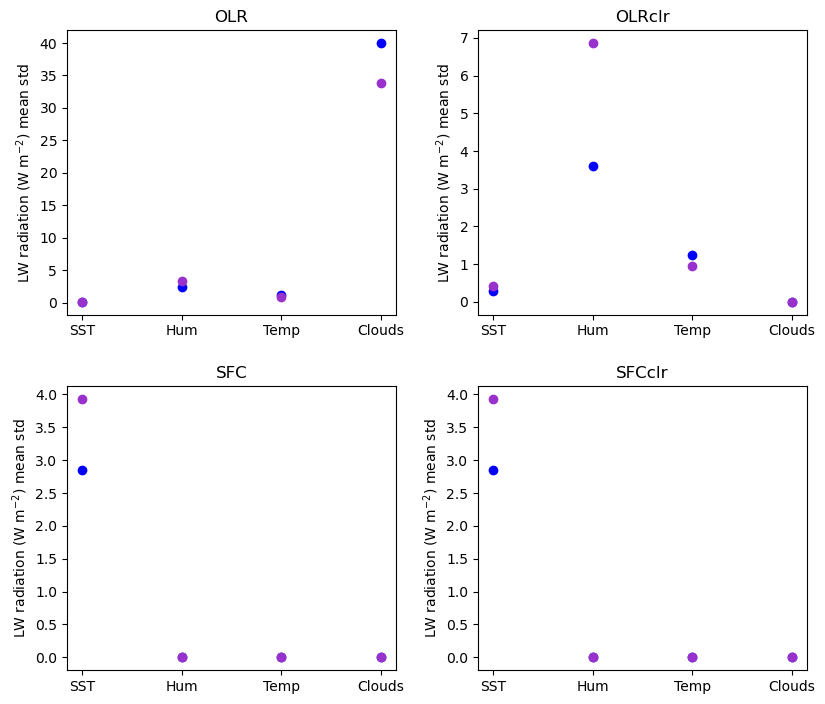

In [350]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.25, wspace=0.25, top=0.9, bottom=0.1)
for i,rad in enumerate(rads):
    ax=subplot(gs[i])
    plt.scatter(varis,mat_r_in_o[:,i], color = 'blue')
    plt.scatter(varis,mat_o_in_r[:,i], color = 'darkorchid')
    plt.title(rad)
    plt.ylabel('LW radiation (W m$^{-2}$) mean std')

## All experiments!

In [248]:
def plot_exps(varis,rad,df_exp):
    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.25, wspace=0.4, top=0.9, bottom=0.1)
    for i,var in enumerate(varis):
        ax=subplot(gs[i])
        plt.scatter(np.arange(0,len(df_exp[var+'_o_in_r_'+rad])), df_exp[var+'_o_in_r_'+rad]*-1, 
                    color = 'darkorchid', alpha=0.5)
        plt.scatter(np.arange(0,len(df_exp[var+'_r_in_o_'+rad])), df_exp[var+'_r_in_o_'+rad]*-1, 
                    color = 'blue', alpha=0.5)
        plt.title(var)
    plt.suptitle(rad)
    plt.show()

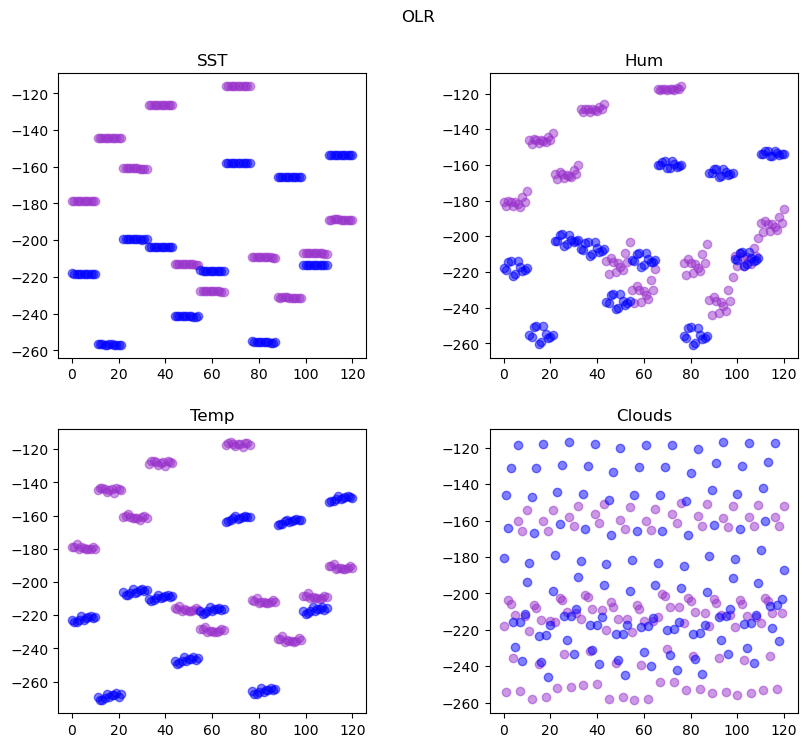

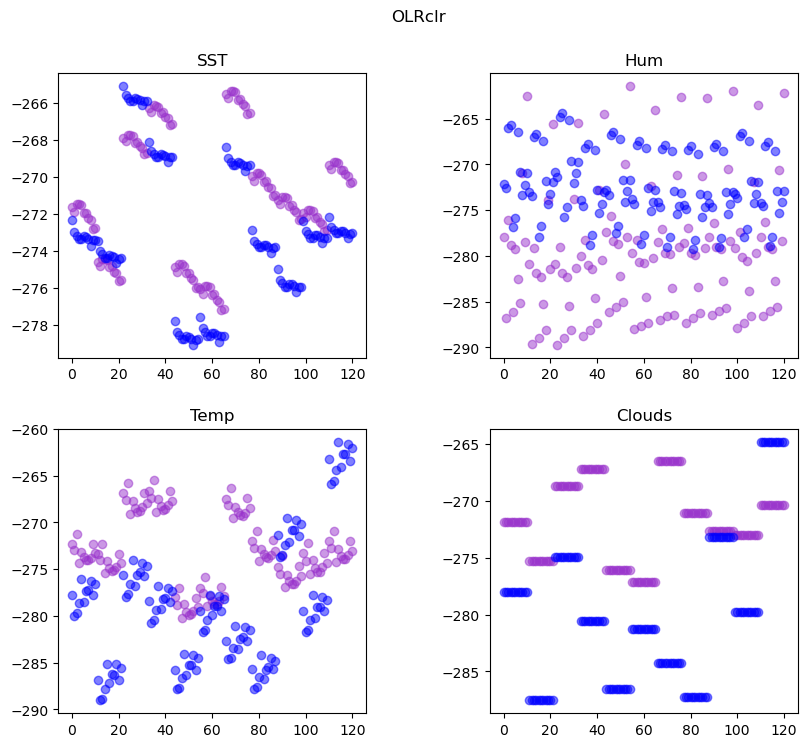

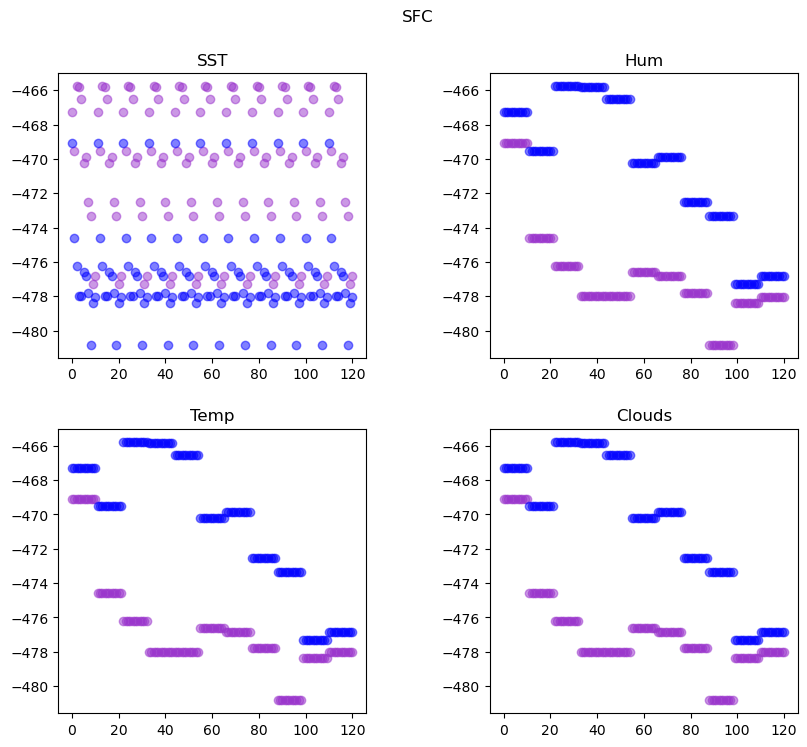

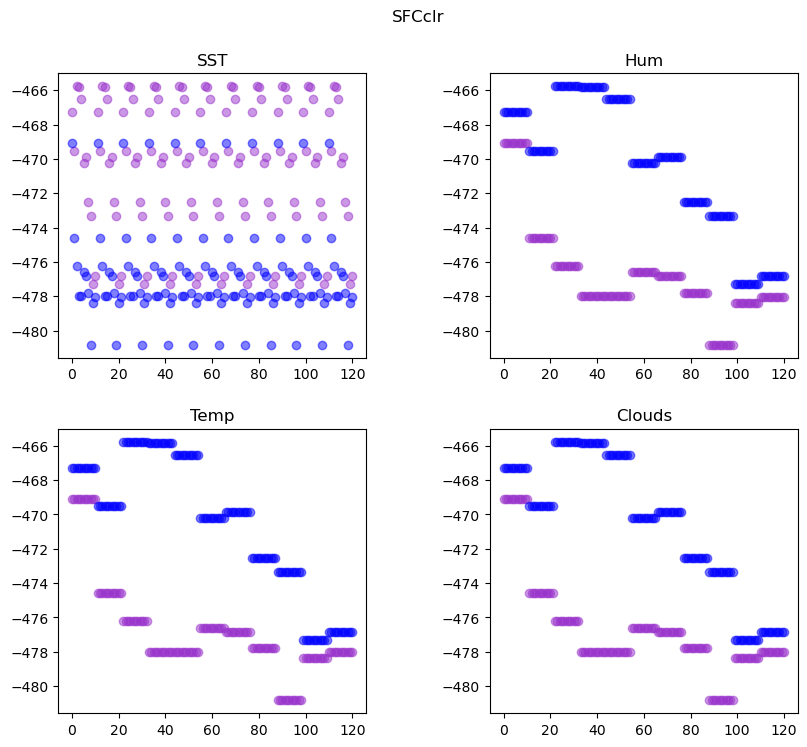

In [249]:
rads = ['OLR','OLRclr','SFC','SFCclr']

for rad in rads:
    plot_exps(varis,rad,df_exp)


### Artificial experiments

In [55]:
### 2N-9N
r_ice = 25.
r_liq = 14.
exp_vals = {}
exp_vals['SST'] = 0,0,0,0,0,-1,1,0,0
exp_vals['Cfr'] = 1,1,1,1,1,1,1,0.5,1.5
exp_vals['ciw'] = 1,0.5,1.5,1,1,1,1,1,1
exp_vals['clw'] = 1,1,1,0.5,1.5,1,1,1,1

n_2 = ['2-9','2-9_0p5_ice','2-9_1p5_ice','2-9_0p5_liq','2-9_1p5_ice',
       '2-9_-1_sst','2-9_1_sst','2-9_0p5_cfrac','2-9_1p5_cfrac']
n_3 = ['3-10','3-10_0p5_ice','3-10_1p5_ice','3-10_0p5_liq','3-10_1p5_ice',
       '3-10_-1_sst','3-10_1_sst','3-10_0p5_cfrac','3-10_1p5_cfrac']
n_3s = ['3S4N-9','3S-4N_0p5_ice','3S-4N_1p5_ice','3S-4N_0p5_liq','3S-4N_1p5_ice',
       '3S-4N_-1_sst','3S-4N_1_sst','3S-4N_0p5_cfrac','3S-4N_1p5_cfrac']

exp_rev = {}
exp_org = {}
for i,sst in enumerate(exp_vals['SST']):
    print('Exp '+str(i+1)+' of '+str(len(exp_vals['Cfr'])))
    print('Reversals')
    rev = RRTMG_nat(mlo2['SST']+sst,sph_lo2,cfrac_lo2*exp_vals['Cfr'][i],tt2_lo2,
                        r_ice,{'med': exp_vals['ciw'][i]*mlo2['ciwp'].mean()*1000,},
                        r_liq,{'med': exp_vals['clw'][i]*mlo2['clwp'].mean()*1000,},
                        np.array(pres_long), False)
    exp_rev[n_2[i]] = rev
    
    rev = RRTMG_nat(mlo3['SST']+sst,sph_lo3,cfrac_lo3*exp_vals['Cfr'][i],tt2_lo3,
                        r_ice,{'med': exp_vals['ciw'][i]*mlo3['ciwp'].mean()*1000,},
                        r_liq,{'med': exp_vals['clw'][i]*mlo3['clwp'].mean()*1000,},
                        np.array(pres_long), False)
    exp_rev[n_3[i]] = rev
    
    rev = RRTMG_nat(mlo3s['SST']+sst,sph_lo3s,cfrac_lo3s*exp_vals['Cfr'][i],tt2_lo3s,
                        r_ice,{'med': exp_vals['ciw'][i]*mlo3s['ciwp'].mean()*1000,},
                        r_liq,{'med': exp_vals['clw'][i]*mlo3s['clwp'].mean()*1000,},
                        np.array(pres_long), False)
    exp_rev[n_3s[i]] = rev
    
    ################### ----------------------- ###################
    
    print('Organised')
    org = RRTMG_nat(mhi2['SST']+sst,sph_hi2,cfrac_hi2*exp_vals['Cfr'][i],tt2_hi2,
                        r_ice,{'med': exp_vals['ciw'][i]*mhi2['ciwp'].mean()*1000,},
                        r_liq,{'med': exp_vals['clw'][i]*mhi2['clwp'].mean()*1000,},
                        np.array(pres_long), False)
    exp_org[n_2[i]] = org
    
    org = RRTMG_nat(mhi3['SST']+sst,sph_hi3,cfrac_hi3*exp_vals['Cfr'][i],tt2_hi3,
                        r_ice,{'med': exp_vals['ciw'][i]*mhi3['ciwp'].mean()*1000,},
                        r_liq,{'med': exp_vals['clw'][i]*mhi3['clwp'].mean()*1000,},
                        np.array(pres_long), False)
    exp_org[n_3[i]] = org
    
    org = RRTMG_nat(mhi3s['SST']+sst,sph_hi3s,cfrac_hi3s*exp_vals['Cfr'][i],tt2_hi3s,
                        r_ice,{'med': exp_vals['ciw'][i]*mhi3s['ciwp'].mean()*1000,},
                        r_liq,{'med': exp_vals['clw'][i]*mhi3s['clwp'].mean()*1000,},
                        np.array(pres_long), False)
    exp_org[n_3s[i]] = org


Exp 1 of 9
Reversals
Organised
Exp 2 of 9
Reversals
Organised
Exp 3 of 9
Reversals
Organised
Exp 4 of 9
Reversals
Organised
Exp 5 of 9
Reversals
Organised
Exp 6 of 9
Reversals
Organised
Exp 7 of 9
Reversals
Organised
Exp 8 of 9
Reversals
Organised
Exp 9 of 9
Reversals
Organised


In [130]:
reversal = {'2-9_OLR':[],'2-9_SFC':[],'2-9_OLRclr':[],'2-9_SFCclr':[],
            '3-10_OLR':[],'3-10_SFC':[],'3-10_OLRclr':[],'3-10_SFCclr':[],
            '3S-4N_OLR':[],'3S-4N_SFC':[],'3S-4N_OLRclr':[],'3S-4N_SFCclr':[]}
organised = {'2-9_OLR':[],'2-9_SFC':[],'2-9_OLRclr':[],'2-9_SFCclr':[],
            '3-10_OLR':[],'3-10_SFC':[],'3-10_OLRclr':[],'3-10_SFCclr':[],
            '3S-4N_OLR':[],'3S-4N_SFC':[],'3S-4N_OLRclr':[],'3S-4N_SFCclr':[]}

names = [n_2,n_3,n_3s]
areas = ['2-9','3-10','3S-4N']

for i,name in enumerate(names):
    for var in name: 
        reversal[areas[i]+'_OLR'].append(exp_rev[var].LW_flux_up[0]*-1)
        reversal[areas[i]+'_SFC'].append(exp_rev[var].LW_flux_up[-1]*-1)
        reversal[areas[i]+'_OLRclr'].append(exp_rev[var].LW_flux_up_clr[0]*-1)
        reversal[areas[i]+'_SFCclr'].append(exp_rev[var].LW_flux_up_clr[-1]*-1)
        organised[areas[i]+'_OLR'].append(exp_org[var].LW_flux_up[0]*-1)
        organised[areas[i]+'_SFC'].append(exp_org[var].LW_flux_up[-1]*-1)
        organised[areas[i]+'_OLRclr'].append(exp_org[var].LW_flux_up_clr[0]*-1)
        organised[areas[i]+'_SFCclr'].append(exp_org[var].LW_flux_up_clr[-1]*-1)

# Let's try a column model, maybe prove it with RRTMG and the mean conditions

In [ ]:
## '2N-9N'
tt2_lo2 = vert_means(mlo2, temp2)
sph_lo2 = vert_means(mlo2, sphum)

tt2_hi2 = vert_means(mhi2, temp2)
sph_hi2 = vert_means(mhi2, sphum)

## '3N-10N'
tt2_lo3 = vert_means(mlo3, temp2)
sph_lo3 = vert_means(mlo3, sphum)

tt2_hi3 = vert_means(mhi3, temp2)
sph_hi3 = vert_means(mhi3, sphum)

## '3S-4N'
tt2_lo3s = vert_means(mlo3s, temp2)
sph_lo3s = vert_means(mlo3s, sphum)

tt2_hi3s = vert_means(mhi3s, temp2)
sph_hi3s = vert_means(mhi3s, sphum)

### Clouds
## '2N-9N'
cfrac_lo2 = vert_means(mlo2, cover)

cfrac_hi2 = vert_means(mhi2, cover)

## '3N-10N'
cfrac_lo3 = vert_means(mlo3, cover)

cfrac_hi3 = vert_means(mhi3, cover)

## '3S-4N'
cfrac_lo3s = vert_means(mlo3s, cover)

cfrac_hi3s = vert_means(mhi3s, cover)

In [ ]:
#ciwp = {'thin': 20.,
#        'med': 60.,
#        'thick': 200.,}

r_ice = 25.
r_liq = 14.
### 2N-9N
rev2_diag,rev2lw_cre,rev2sw_cre = RRTMG_nat(mlo2['SST'],sph_lo2,cfrac_lo2,tt2_lo2,
                                            r_ice,{'med': mlo2['ciwp'].mean()*1000,},
                                            r_liq,{'med': mlo2['clwp'].mean()*1000,},
                                            np.array(pres_long), False)
org2_diag,org2lw_cre,org2sw_cre = RRTMG_nat(mhi2['SST'],sph_hi2,cfrac_hi2,tt2_hi2,
                                            r_ice,{'med': mhi2['ciwp'].mean()*1000,},
                                            r_liq,{'med': mhi2['clwp'].mean()*1000,},
                                            np.array(pres_long), False)

### 3N-10N
rev3_diag,rev3lw_cre,rev3sw_cre = RRTMG_nat(mlo3['SST'],sph_lo3,cfrac_lo3,tt2_lo3,
                                            r_ice,{'med': mlo3['ciwp'].mean()*1000,},
                                            r_liq,{'med': mlo3['clwp'].mean()*1000,}, 
                                            np.array(pres_long), False)
org3_diag,org3lw_cre,org3sw_cre = RRTMG_nat(mhi3['SST'],sph_hi3,cfrac_hi3,tt2_hi3,
                                            r_ice,{'med': mhi3['ciwp'].mean()*1000,},
                                            r_liq,{'med': mhi3['clwp'].mean()*1000,},
                                            np.array(pres_long), False)

### 3S-4N
rev3s_diag,rev3slw_cre,rev3ssw_cre = RRTMG_nat(mlo3s['SST'],sph_lo3s,cfrac_lo3s,tt2_lo3s,
                                               r_ice,{'med': mlo3s['ciwp'].mean()*1000,},
                                               r_liq,{'med': mlo3s['clwp'].mean()*1000,},
                                               np.array(pres_long), False)
org3s_diag,org3slw_cre,org3ssw_cre = RRTMG_nat(mhi3s['SST'],sph_hi3s,cfrac_hi3s,tt2_hi3s,
                                               r_ice,{'med': mhi3s['ciwp'].mean()*1000,},
                                               r_liq,{'med': mhi3s['clwp'].mean()*1000,}, 
                                               np.array(pres_long), False)

In [ ]:
RRTMG_real = {}
RRTMG_real['OLR_revs'] = rev2_diag.LW_flux_up[0]*-1, rev3_diag.LW_flux_up[0]*-1, rev3s_diag.LW_flux_up[0]*-1
RRTMG_real['OLR_orgs'] = org2_diag.LW_flux_up[0]*-1, org3_diag.LW_flux_up[0]*-1, org3s_diag.LW_flux_up[0]*-1
RRTMG_real['OLRclr_revs'] = rev2_diag.LW_flux_up_clr[0]*-1, rev3_diag.LW_flux_up_clr[0]*-1, rev3s_diag.LW_flux_up_clr[0]*-1
RRTMG_real['OLRclr_orgs'] = org2_diag.LW_flux_up_clr[0]*-1, org3_diag.LW_flux_up_clr[0]*-1, org3s_diag.LW_flux_up_clr[0]*-1

RRTMG_real['SFC_revs'] = rev2_diag.LW_flux_up[-1]*-1, rev3_diag.LW_flux_up[-1]*-1, rev3s_diag.LW_flux_up[-1]*-1
RRTMG_real['SFC_orgs'] = org2_diag.LW_flux_up[-1]*-1, org3_diag.LW_flux_up[-1]*-1, org3s_diag.LW_flux_up[-1]*-1
RRTMG_real['SFCclr_revs'] = rev2_diag.LW_flux_up_clr[-1]*-1, rev3_diag.LW_flux_up_clr[-1]*-1, rev3s_diag.LW_flux_up_clr[-1]*-1
RRTMG_real['SFCclr_orgs'] = org2_diag.LW_flux_up_clr[-1]*-1, org3_diag.LW_flux_up_clr[-1]*-1, org3s_diag.LW_flux_up_clr[-1]*-1

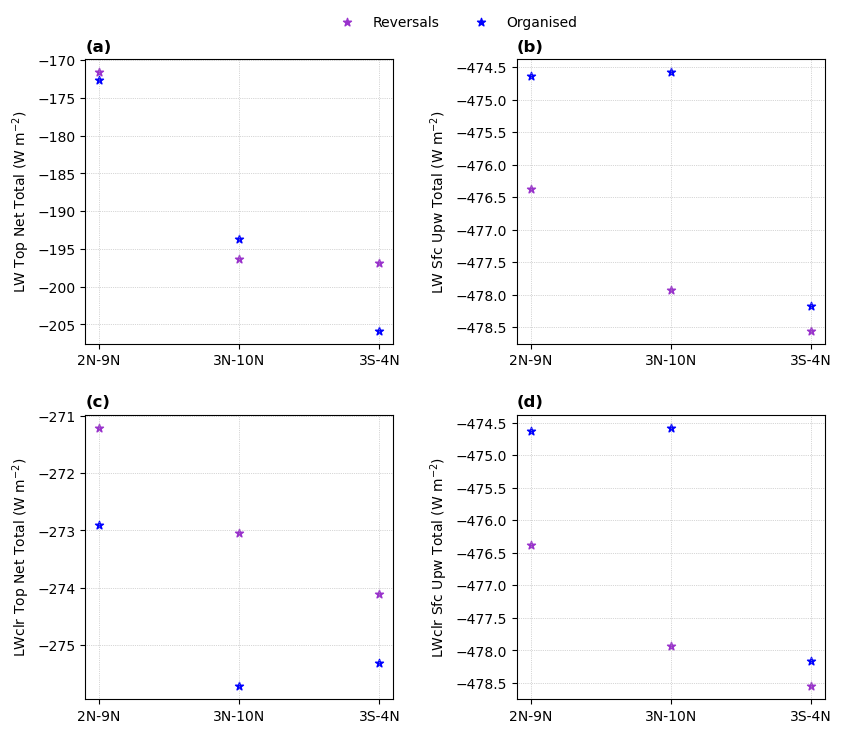

In [35]:
revs = [RRTMG_real['OLR_revs'], RRTMG_real['SFC_revs'], RRTMG_real['OLRclr_revs'], RRTMG_real['SFCclr_revs']]
orgs = [RRTMG_real['OLR_orgs'], RRTMG_real['SFC_orgs'], RRTMG_real['OLRclr_orgs'], RRTMG_real['SFCclr_orgs']]
plot_sct_RRTMG(revs,orgs)
plt.savefig(path+'Fig_RRTMG_OLR_SFC_TOA.pdf', bbox_inches='tight', dpi=300)

# Verticals!

## LW radiative cooling!

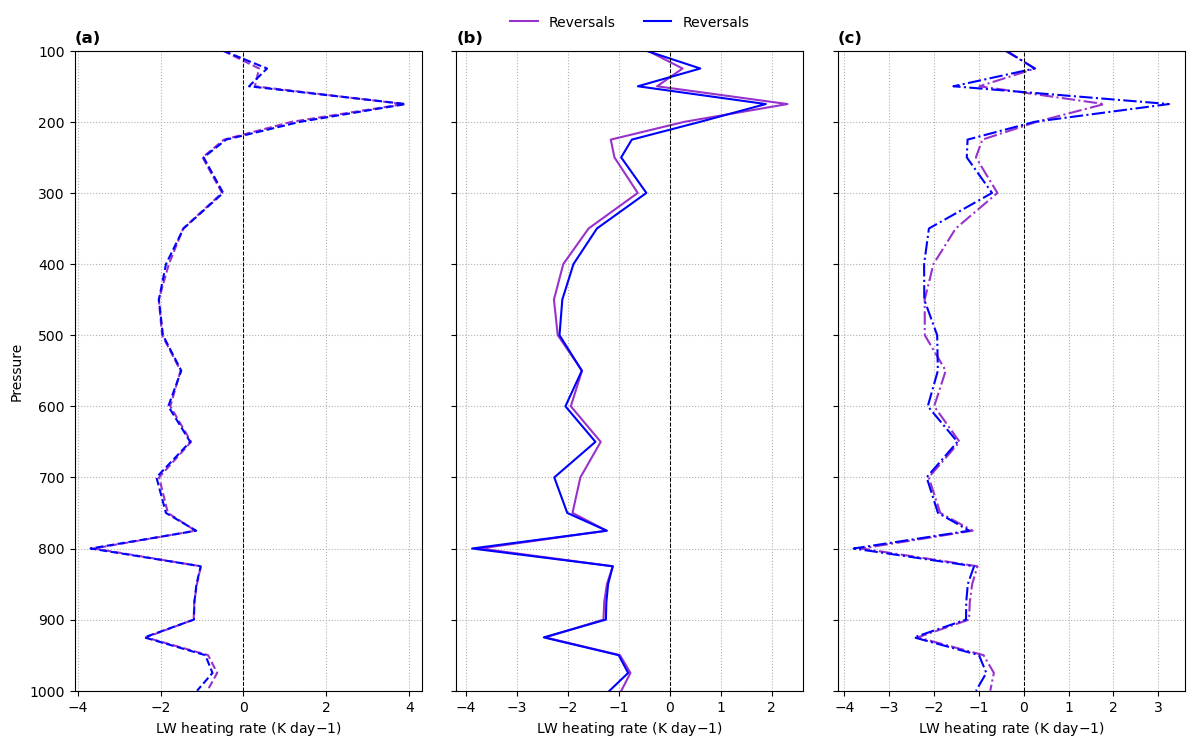

In [12]:
revs = [rev2_diag.TdotLW, rev3_diag.TdotLW, rev3s_diag.TdotLW]
orgis = [org2_diag.TdotLW, org3_diag.TdotLW, org3s_diag.TdotLW]
plot_vert_rrtmg(revs,orgis,'LW heating rate (K day${-1}$)')
plt.savefig(path+'Fig_LW_rad_cooling.pdf', bbox_inches='tight', dpi=300)

## LW clear-sky radiative cooling!

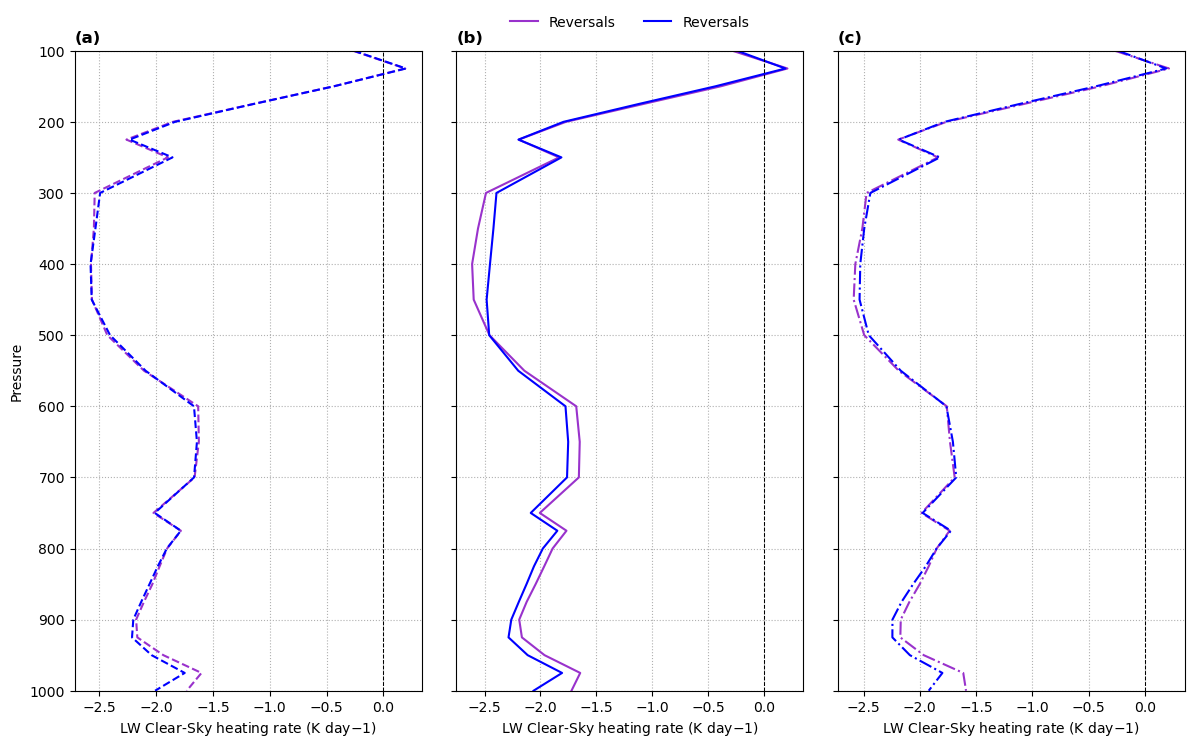

In [13]:
revs = [rev2_diag.TdotLW_clr, rev3_diag.TdotLW_clr, rev3s_diag.TdotLW_clr]
orgis = [org2_diag.TdotLW_clr, org3_diag.TdotLW_clr, org3s_diag.TdotLW_clr]
plot_vert_rrtmg(revs,orgis, 'LW Clear-Sky heating rate (K day${-1}$)')
plt.savefig(path+'Fig_LW_clr_rad_cooling.pdf', bbox_inches='tight', dpi=300)

## LW CRE radiative cooling!

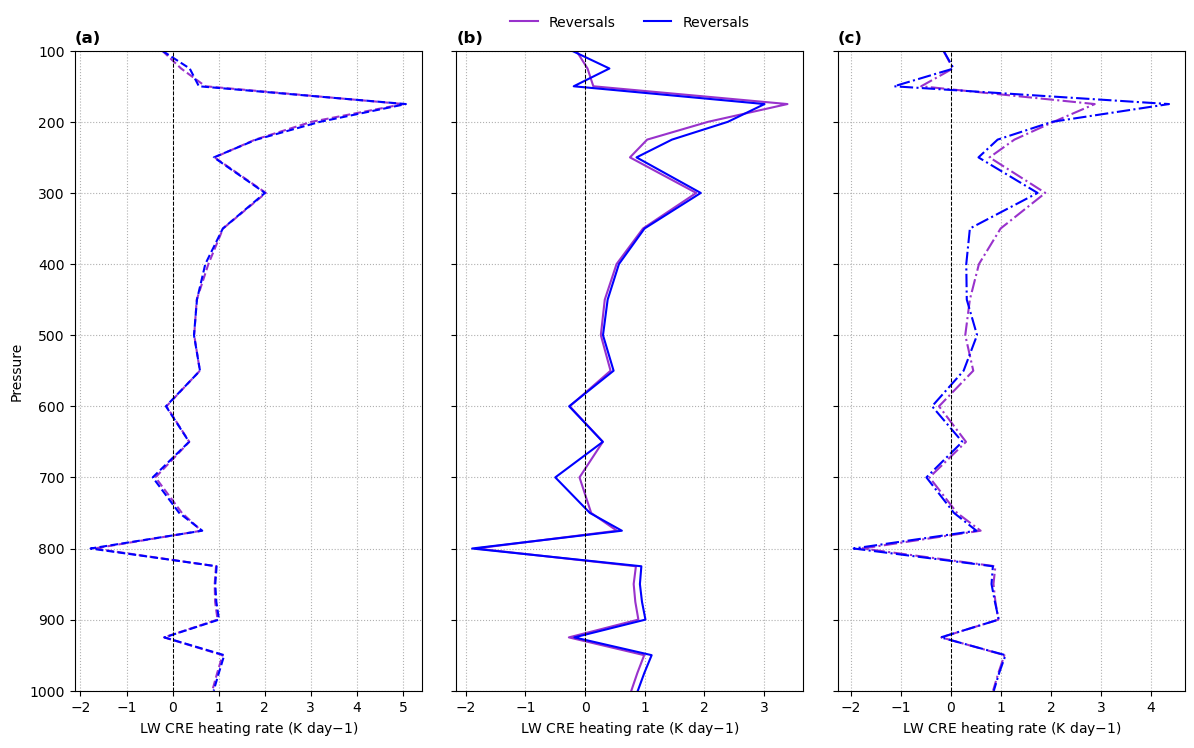

In [14]:
revs = [np.array(rev2lw_cre['med']), np.array(rev3lw_cre['med']), np.array(rev3slw_cre['med'])]
orgis = [np.array(org2lw_cre['med']), np.array(org3lw_cre['med']), np.array(org3slw_cre['med'])]
plot_vert_rrtmg(revs,orgis, 'LW CRE heating rate (K day${-1}$)')